In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import optax
import gym
import numpy as np
import matplotlib.pyplot as plt
from jax import jit
from functools import partial
from typing import Union, Optional, Any

In [2]:
def get_true_model(params):
  g, m, l = params
  dt = 0.05
  max_speed = 8
  max_torque = 2

  @jit
  def predict(key, obs, action):
    u = jnp.clip(action + jr.normal(key), -max_torque, max_torque)
    th, thdot = obs[:2]
    th = angle_from_state(obs)
    thdot = obs[2]
    newthdot = thdot + (3 * g / (2 * l) * jnp.sin(th) + 3.0 / (m * l**2) * u) * dt
    newthdot = jnp.clip(newthdot, -max_speed, max_speed)
    newth = th + newthdot * dt
    return jnp.asarray([jnp.cos(newth), jnp.sin(newth), newthdot], dtype=np.float32)

  return predict

params = (9.81, 1.0, 1.0)
true_model = get_true_model(params)
true_param = jnp.array(params)

In [3]:
ce_params = jnp.array([[9.81, 0.9, 1.0]])
dr_params = jnp.array([[9.81, 0.8, 1.0],
                       [9.81, 0.9, 1.0],
                       [9.81, 1.0, 1.0]])

In [4]:
@jit
def angle_from_state(state):
    cos_th, sin_th, _ = state
    return jnp.arctan2(sin_th, cos_th)
@jit
def cost_function(state, action):
    theta = angle_from_state(state)
    theta_dot = state[2]
    return jax.lax.cond(theta**2 < (jnp.pi/4)**2, lambda: (theta)**2 + 0.1*(theta_dot**2) + 2.0*(action**2), lambda: 50.0)

def predict(obs, action, param):

  g, m, l = param
  max_speed = 8
  max_torque = 2
  dt = 0.05
  u = jnp.clip(action, -max_torque, max_torque)
  th, thdot = obs[:2]
  th = angle_from_state(obs)
  thdot = obs[2]
  newthdot = thdot + (3 * g / (2 * l) * jnp.sin(th) + 3.0 / (m * l**2) * u) * dt
  newthdot = jnp.clip(newthdot, -max_speed, max_speed)
  newth = th + newthdot * dt
  return jnp.asarray([jnp.cos(newth), jnp.sin(newth), newthdot], dtype=np.float32)

@jit
def rollout_cost_target(params, init_state, seq):
    average_cost = 0.0
    for param in params:
      total_cost = 0.0
      s = init_state
      for a in seq:
          total_cost += cost_function(s, a)
          s = predict(s,a,param)
      average_cost += total_cost/len(params)
    return average_cost

@partial(jit, static_argnums=(3,4,5,6,7,8))
def cem_planner(
    params,
    current_state,
    subkey,
    horizon=20,
    n_samples=1000,
    n_elite=100,
    n_iterations=10,
    action_min=-2.0,
    action_max=2.0,
):
    key = subkey
    mean = jnp.zeros((horizon, 1))
    std = jnp.ones((horizon, 1)) * 0.5

    @partial(jit, static_argnums=(3,))
    def sample_actions(rng_key, mean, std, n_samples):
        eps = jr.normal(rng_key, shape=(n_samples, horizon))
        seq = mean + std * eps
        return jnp.clip(seq, action_min, action_max)

    @jit
    def step(carry, key):
        mean, std = carry
        seqs = sample_actions(key, mean[:, 0], std[:, 0], n_samples)  # (n_samples, horizon

        costs = jax.vmap(lambda seq: rollout_cost_target(params, current_state, seq))(seqs)
        idx_sorted = jnp.argsort(costs)
        elites = seqs[idx_sorted[:n_elite], :]
        mean = jnp.mean(elites, axis=0)
        std = jnp.std(elites, axis=0) + 1e-6
        return (mean[:,None], std[:,None]), None

    keys = jr.split(key, n_iterations)
    (mean, std), _ = jax.lax.scan(step, (mean, std), keys)

    best_sequence = mean
    best_action = jnp.clip(best_sequence[0][0], action_min, action_max)
    return best_action

@jit
def step(carry, keys):
  key1, key2 = keys
  s, reward, params = carry
  a = cem_planner(params, s, key1)
  a_np = jnp.array([a])
  reward += cost_function(s, a)
  s  = true_model(key2, s, a)
  return (s, reward, params), None

@jit
def single_evaluate(params, key, traj_length=200):
    s = jnp.array([1.0, 0.0, 0.0])
    reward = 0
    keys = jr.split(key, 2*traj_length)
    dyn_keys = keys[:traj_length]
    act_keys = keys[traj_length:]
    (s, reward, _), _ = jax.lax.scan(step, (s, reward, params), (dyn_keys, act_keys))

    return reward

@partial(jit, static_argnums=(2,))
def evaluate(params, key, n_eval=30):
  eval_keys = jr.split(key, n_eval)
  evaluate_multiple = jax.vmap(single_evaluate, in_axes=(None,0))
  return jnp.mean(evaluate_multiple(params, eval_keys))

# print(evaluate(ce_params, jr.PRNGKey(0)))
# print(evaluate(dr_params, jr.PRNGKey(0)))

In [5]:
ce_params = jnp.array([[9.81, 0.95, 1.0]])
print(evaluate(ce_params, jr.PRNGKey(0)))

362.14877


In [6]:
def collect_step(carry, keys):
  key1, key2 = keys
  s, reward, params = carry
  a = jr.normal(key1)
  a_np = jnp.array([a])
  snext  = true_model(key2, s, a)
  return (snext, reward, params), (s,a)

@partial(jit, static_argnums=(1,))
def collect_traj(key, traj_length=10):
  s = jnp.array([-1.0, 0.0, 0.0])
  reward = 0
  keys = jr.split(key, (2, traj_length))
  (s_final, _, _), (states, actions) = jax.lax.scan(collect_step, (s, reward, ce_params), (keys[0], keys[1]))
  targets = jnp.vstack([states[1:], s_final[None,:]])
  return targets, (states, actions)

@partial(jit, static_argnums=(1,))
def collect_data(key, n_traj):
  keys = jr.split(key, n_traj)
  collect_multiple = jax.vmap(collect_traj, in_axes=(0))
  return collect_multiple(keys)

In [7]:
from jax.scipy.optimize import minimize
vmapped_predict = jax.vmap(predict, in_axes=(0,0,None))

def est_params(data):
  target, (states, actions) = data

  def loss(params):
    return jnp.mean((vmapped_predict(states.reshape(-1,3), actions.reshape(-1), params) - target.reshape(-1,3))**2)

  result = minimize(loss, jnp.array([9.81, 1.0, 1.0]), method='BFGS')
  return result.x

# @partial(jit, static_argnums=(1,))
def get_estimates(data, n_traj_list):
  estimated_params = []
  target, (states, actions) = data
  for n_traj in n_traj_list:
    estimated_params.append(est_params((target[:n_traj], (states[:n_traj], actions[:n_traj]))))
  return jnp.vstack(estimated_params)

In [8]:
#1 Collect data and perform identification as you were doing before. However, do so using the same noise level as is here.
#to make the average estimation error higher or lower, just change the amount of data used for identification

estimated_params = []
n_traj_tuple = (10, 25, 50, 100, 150, 200)
n_trials = 100

key = jr.PRNGKey(999)
estimated_params = []
for i in range(n_trials):
  print(f'trial {i}')
  key, subkey = jr.split(key)
  data = collect_data(subkey, n_traj_tuple[-1])
  estimated_params.append(get_estimates(data, n_traj_tuple))
estimated_params = jnp.stack(estimated_params)

trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29
trial 30
trial 31
trial 32
trial 33
trial 34
trial 35
trial 36
trial 37
trial 38
trial 39
trial 40
trial 41
trial 42
trial 43
trial 44
trial 45
trial 46
trial 47
trial 48
trial 49
trial 50
trial 51
trial 52
trial 53
trial 54
trial 55
trial 56
trial 57
trial 58
trial 59
trial 60
trial 61
trial 62
trial 63
trial 64
trial 65
trial 66
trial 67
trial 68
trial 69
trial 70
trial 71
trial 72
trial 73
trial 74
trial 75
trial 76
trial 77
trial 78
trial 79
trial 80
trial 81
trial 82
trial 83
trial 84
trial 85
trial 86
trial 87
trial 88
trial 89
trial 90
trial 91
trial 92
trial 93
trial 94
trial 95
trial 96
trial 97
trial 98
trial 99


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


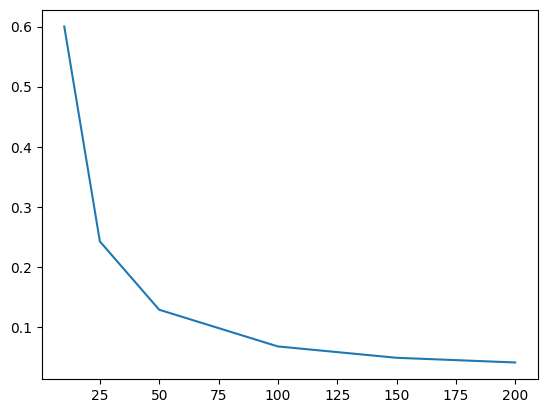

In [9]:
mean = jnp.mean(jnp.sum((estimated_params - true_param[None, None, :])**2, axis=2), axis=0)
std = jnp.std(jnp.sum((estimated_params - true_param[None, None, :])**2, axis=2), axis=0)

plt.plot(n_traj_tuple, mean)

In [10]:
#2 Set some number of samples to use for DR. Perhaps about 10. Sample these values from mean estiamte +- (hp1, hp2, hp3)/(# samples used to fit estimate),
#where hp1, hp2, and hp3 are hyperparameters used to determine the amount of randomization

def randomize_params(key, params, scale, n_rand=15):
  randomization_directions = jr.normal(key, shape=(n_rand, 3))
  randomization_directions = randomization_directions/jnp.linalg.norm(randomization_directions, axis=1, keepdims=True)
  return params[None,:] + scale*randomization_directions

ce_params = estimated_params[:,:,None,:]

dr_scales = []
max_perturbation = 2.0
for n_traj in n_traj_tuple:
  dr_scales.append(max_perturbation/n_traj)
dr_scales = jnp.array(dr_scales)

dr_params = []
for i in range(n_trials):
  dr_params_trial = []
  for j in range(len(n_traj_tuple)):
    key, subkey = jr.split(key)
    dr_params_trial.append(randomize_params(subkey, estimated_params[i,j], dr_scales[j]))
  dr_params.append(jnp.stack(dr_params_trial))
dr_params = jnp.stack(dr_params)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
#3 run the evaluate function

evaluate_traj = jit(jax.vmap(lambda params, key: evaluate(params,key), in_axes=(0,0)))

all_ce_rewards = []
all_dr_rewards = []
for trial in range(n_trials):
  print(f'Running trial {trial} evaluation')
  key, subkey = jr.split(key)
  eval_trial_keys = jr.split(subkey, len(n_traj_tuple))
  all_ce_rewards.append(evaluate_traj(ce_params[trial], eval_trial_keys))
  all_dr_rewards.append(evaluate_traj(dr_params[trial], eval_trial_keys))

all_ce_rewards = jnp.stack(all_ce_rewards)
all_dr_rewards = jnp.stack(all_dr_rewards)

Running trial 0 evaluation
Running trial 1 evaluation
Running trial 2 evaluation
Running trial 3 evaluation
Running trial 4 evaluation
Running trial 5 evaluation
Running trial 6 evaluation
Running trial 7 evaluation
Running trial 8 evaluation
Running trial 9 evaluation
Running trial 10 evaluation
Running trial 11 evaluation
Running trial 12 evaluation
Running trial 13 evaluation
Running trial 14 evaluation
Running trial 15 evaluation
Running trial 16 evaluation
Running trial 17 evaluation
Running trial 18 evaluation
Running trial 19 evaluation
Running trial 20 evaluation
Running trial 21 evaluation
Running trial 22 evaluation
Running trial 23 evaluation
Running trial 24 evaluation
Running trial 25 evaluation
Running trial 26 evaluation
Running trial 27 evaluation
Running trial 28 evaluation
Running trial 29 evaluation
Running trial 30 evaluation
Running trial 31 evaluation
Running trial 32 evaluation
Running trial 33 evaluation
Running trial 34 evaluation
Running trial 35 evaluation
Ru

In [12]:
ce_mean = jnp.mean(all_ce_rewards, axis=0)
ce_std = jnp.std(all_ce_rewards, axis=0)

dr_mean = jnp.mean(all_dr_rewards, axis=0)
dr_std = jnp.std(all_dr_rewards, axis=0)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
print(f"CE mean: {ce_mean}")
print(f"CE std: {ce_std}")
print(f"DR mean: {dr_mean}")
print(f"DR std: {dr_std}")

CE mean: [846.75323 527.20465 380.99728 344.48245 323.85342 319.67404]
CE std: [1349.0392   587.7926   192.20813  110.62243   80.5776    76.37928]
DR mean: [700.8178  361.37857 301.00906 286.27335 279.64578 290.9798 ]
DR std: [1124.0835   412.67456  136.20757   87.42824   60.88764   64.88817]


(250.0, 800.0)

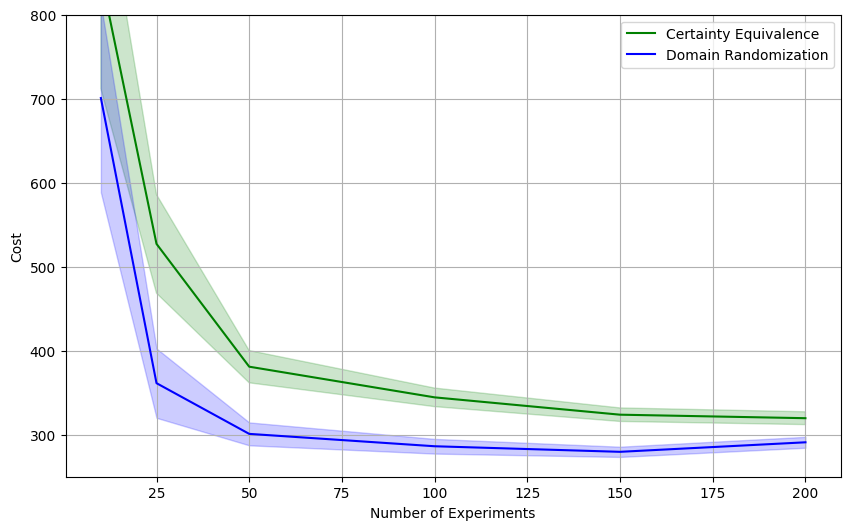

In [14]:
plt.figure(figsize=(10, 6))

plt.plot(n_traj_tuple, ce_mean, color='g', label='Certainty Equivalence')
plt.plot(n_traj_tuple, dr_mean, color='b', label='Domain Randomization')

plt.fill_between(n_traj_tuple, ce_mean-ce_std/jnp.sqrt(n_trials), ce_mean+ce_std/jnp.sqrt(n_trials), alpha=0.2, color='g')
plt.fill_between(n_traj_tuple, dr_mean-dr_std/jnp.sqrt(n_trials), dr_mean+dr_std/jnp.sqrt(n_trials), alpha=0.2, color='b')

plt.xlabel('Number of Experiments')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)

plt.ylim(250, 800)